In [1]:
library(dplyr)
library(ggplot2)
library(zeallot)
library(cowplot)

Warning message:
"pakiet 'dplyr' został zbudowany w wersji R 4.1.3"

Dołączanie pakietu: 'dplyr'


Następujące obiekty zostały zakryte z 'package:stats':

    filter, lag


Następujące obiekty zostały zakryte z 'package:base':

    intersect, setdiff, setequal, union


Warning message:
"pakiet 'ggplot2' został zbudowany w wersji R 4.1.3"
Warning message:
"pakiet 'zeallot' został zbudowany w wersji R 4.1.3"
Warning message:
"pakiet 'cowplot' został zbudowany w wersji R 4.1.3"


In [2]:
analysis <- function(X, Y, display_plot=TRUE){
    spearman <- cor(X, Y, use="pairwise.complete.obs", method="spearman")
    pearson <- cor(X, Y, use="pairwise.complete.obs", method="pearson")
    print(c("Pearson", pearson))
    print(c("Spearman", spearman))
    if (display_plot) {
        ggplot() + geom_point(aes(x=X, y=Y))
    }
}

regression <- function(X, Y, display_plot=TRUE){
    r <- cor(X, Y, use="pairwise.complete.obs")
    Sx <- sd(X)
    Sy <- sd(Y)
    a <- r * Sy / Sx
    b <- mean(Y) - a * mean(X)

    if(display_plot){
        xs <- seq(min(X), max(X), 0.01)
        plt <- ggplot() +
            geom_point(aes(x=X, y=Y), alpha=0.5) +
            geom_line(aes(x = xs, y = a * xs + b), linewidth=1, col="red")
        show(plt)
    }

    return(c(a, b))
}

In [3]:
data <- read.csv("data/data.csv")
data2000 <- data %>% filter(year == 2000)
data2005 <- data %>% filter(year == 2005)
data2010 <- data %>% filter(year == 2010)
data2015 <- data %>% filter(year == 2015)
poland <- data %>% filter(country == "Poland")

[1] "Pearson"           "0.751975462736698"
[1] "Spearman"          "0.813541004769093"


Warning message:
"Removed 170 rows containing missing values (`geom_point()`)."


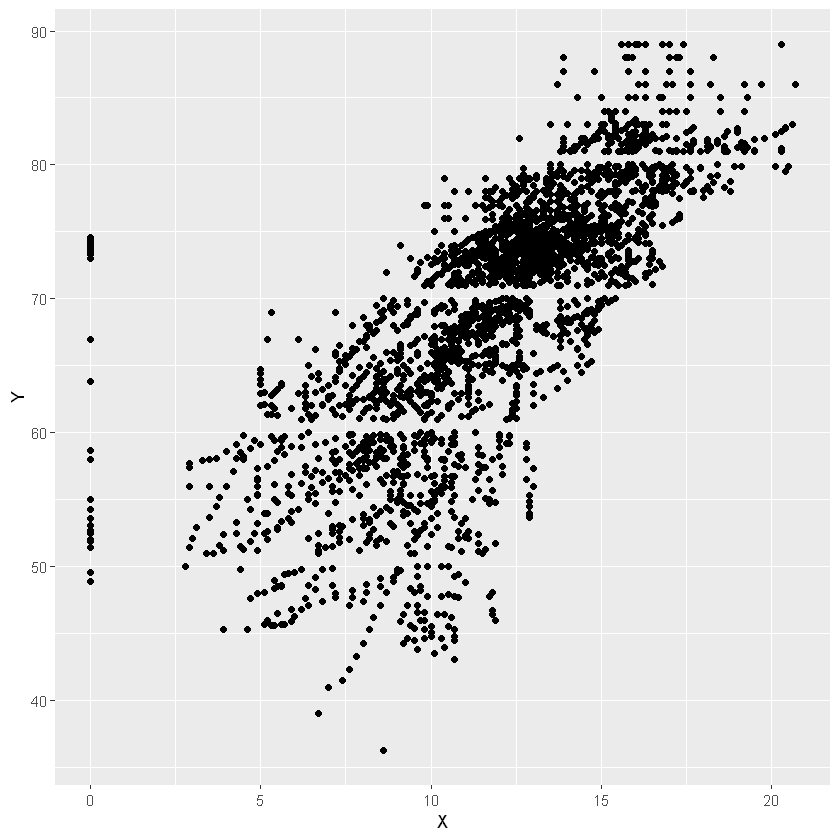

In [4]:
analysis(data$schooling, data$life_expectancy)

In [5]:
df <- data[!is.na(data$schooling) & !is.na(data$life_expectancy) & data$year == 2015,]


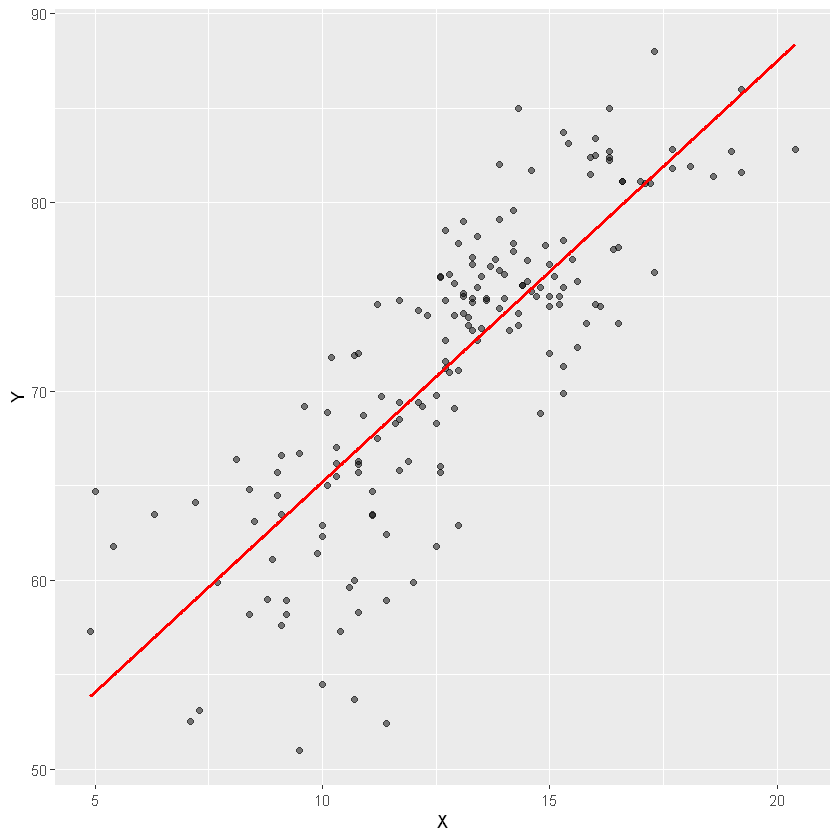

In [6]:
reg <- regression(df$schooling, df$life_expectancy)

In [7]:
reg

[1]  2.228727 42.901591

In [8]:
b0 <- reg[2]
b1 <- reg[1]

In [9]:
x <- df$schooling
y <- df$life_expectancy

# Histogram błędów

In [10]:
e <- y - b1*x - b0
var(e)

[1] 20.80906

In [11]:
ks.test(e, 'pnorm', mean(e), sd(e)) #przyjmujemy że residua są z rozkładu normalnego

Warning message in ks.test(e, "pnorm", mean(e), sd(e)):
"ties should not be present for the Kolmogorov-Smirnov test"



	One-sample Kolmogorov-Smirnov test

data:  e
D = 0.077247, p-value = 0.2532
alternative hypothesis: two-sided


In [12]:
sd(e)

[1] 4.561694

# Predykcja danych próba

In [13]:
x_pred <- seq(17.5, 25, 0.5) #przyszłe wartości x
eps <- rnorm(length(x), 0, sd(e)) #szum
ksi <- rnorm(length(x_pred), 0, sd(e)) #też szum ale dla przyszłych wartości
Y_pred <- b0 + b1*x_pred + ksi #predykowana wartość Y

b1_est <- b1 +  (sum((x - mean(x))*eps))/(sum((x - mean(x))^2)) #estymator b1
b0_est <- b0 + (b1 - b1_est)*mean(x) + mean(eps) #estymator b0


In [14]:
b1_est

[1] 2.220737

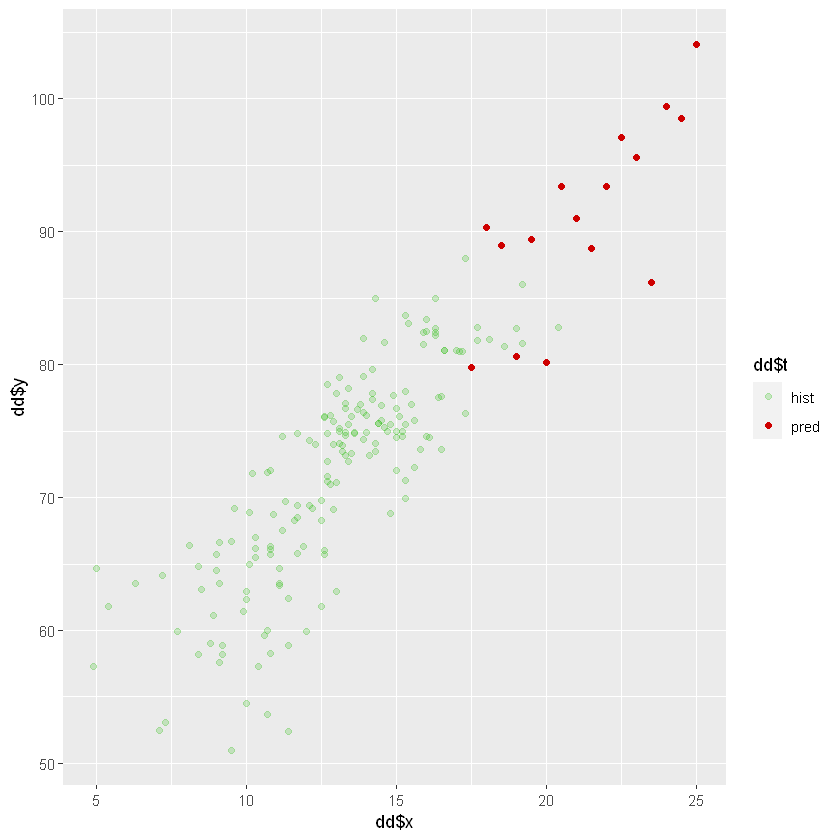

In [15]:
df_hist <- data.frame(x = x, y = y) %>% mutate(t = 'hist')
df_pred <- data.frame(x = x_pred, y = Y_pred) %>% mutate(t = 'pred')
dd <- rbind(df_hist, df_pred)

plt <- ggplot() + geom_point(aes(dd$x, dd$y, col=dd$t, alpha = dd$t)) +
scale_color_manual(values=c('#1cb900', '#ce0000')) + scale_alpha_manual(values = c(0.2, 1))
plt

In [16]:
alpha = 0.05
z <- qnorm(1 - alpha/2)
n <- length(x)
rel <- z*sd(e)*sqrt(1 + 1/n + (x_pred - mean(x))^2/sum((x - mean(x))^2))
Y_pred_est <- b0_est + b1_est*x_pred

In [17]:
l <- Y_pred_est - rel
r <- Y_pred_est + rel
l

[1] 73.08408 74.17983 75.27409 76.36687 77.45818 78.54803 79.63642 80.72337
 [9] 81.80889 82.89299 83.97568 85.05698 86.13689 87.21544 88.29263 89.36848

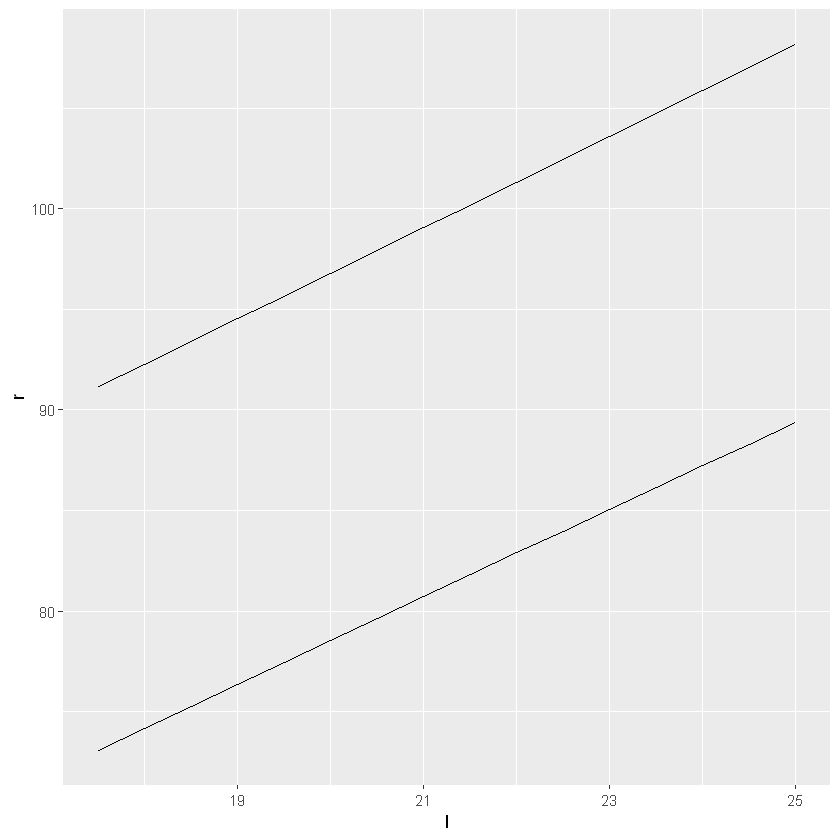

In [18]:
ggplot(data.frame(x = x_pred, l = l, r = r), mapping = aes(l, r)) + geom_line(aes(x, l)) + geom_line(aes(x, r))

In [33]:
pred <- function(x0, x, b0, b1,
                 sigma, alpha, eps){
  z <- qnorm(1 - alpha/2)
  x_sr <- mean(x)
  l_list <- c()
  p_list <- c()
  for(i in 1:1000){
    b1_est <- b1 + (sum((x - x_sr)*eps)) / (sum((x - x_sr)^2))
    b0_est <- b0 + (b1 - b1_est)*x_sr + mean(eps)
    Y0_est <- b0_est + b1_est*x0
    d <- z*sigma*sqrt(1 + 1/n + (x0 - x_sr)^2 / (sum((x - x_sr)^2)))
    l <- Y0_est - d
    p <- Y0_est + d
    l_list <- append(l_list, l)
    p_list <- append(p_list, p)
  }
  l <- mean(l_list)
  p <- mean(p_list)
  return(c(l, p))
}

In [34]:
df2 <- data[!is.na(data$schooling) & !is.na(data$life_expectancy) & data$year == 2014,]
x <- df2$schooling
y <- df2$life_expectancy
b0 <- reg[2]
b1 <- reg[1]
sigma <- sd(e)
alpha <- 0.05
eps <- rnorm(length(x), 0, sigma)
x0 <- seq(16.5, 18, 0.1)
ksi0 <- rnorm(length(x0), 0, sigma)
Y0 <- b0 + b1*x0 + ksi0
preds <- c()
for(i in x0){
   preds <- append(preds, pred(i, x, b0, b1,
                 sigma, alpha, eps)) 
}
preds

[1] 64.98146 92.89515 65.18652 93.10712 65.39148 93.31918 65.59635 93.53133
 [9] 65.80113 93.74357 66.00581 93.95591 66.21040 94.16834 66.41489 94.38087
[17] 66.61930 94.59349 66.82361 94.80620 67.02783 95.01900 67.23195 95.23190
[25] 67.43598 95.44489 67.63992 95.65797 67.84377 95.87114 68.04753 96.08441

In [ ]:
left <- c()
right <- c()
for(pr in preds){
    l <- pr[1]
    r <- pr[2]
    left <- append(left, l)
    right <- append(right, r)
}

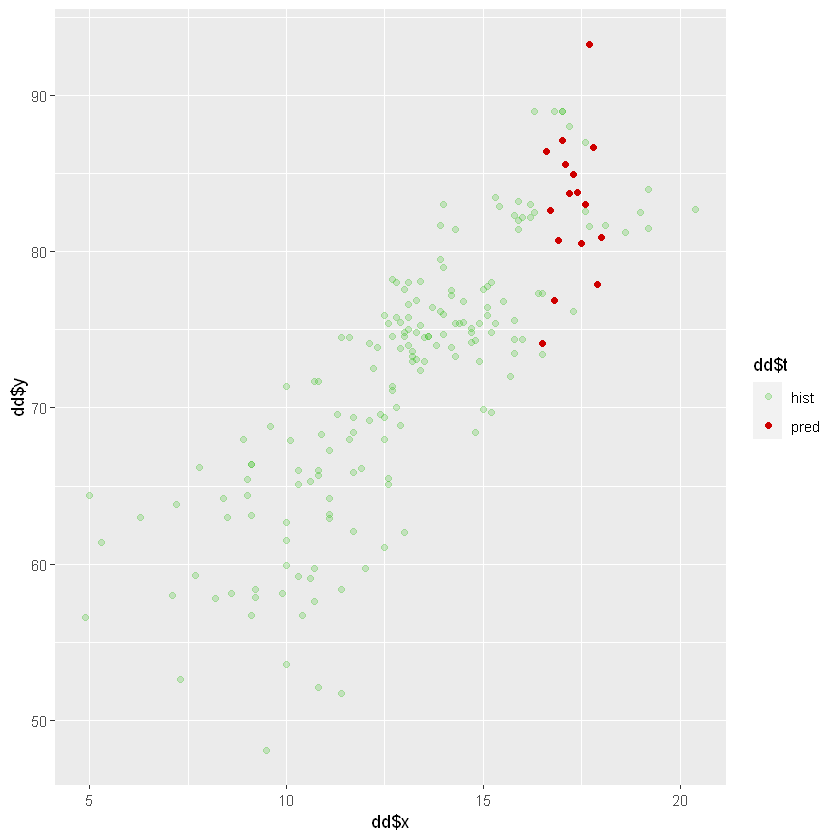

In [35]:
df_hist <- data.frame(x = x, y = y) %>% mutate(t = 'hist')
df_pred <- data.frame(x = x0, y = Y0) %>% mutate(t = 'pred')
dd <- rbind(df_hist, df_pred)

haha <- ggplot() + geom_point(aes(dd$x, dd$y, col=dd$t, alpha = dd$t)) +
scale_color_manual(values=c('#1cb900', '#ce0000')) + scale_alpha_manual(values = c(0.2, 1))
plt

# Analiza GDP

In [19]:
df2 <- data[(!is.na(data$GDP)) & (!is.na(data$life_expectancy)) & (data$year == 2015),]
scat2 <- ggplot(data = df2, mapping = aes(x = GDP, y = life_expectancy)) + geom_point()

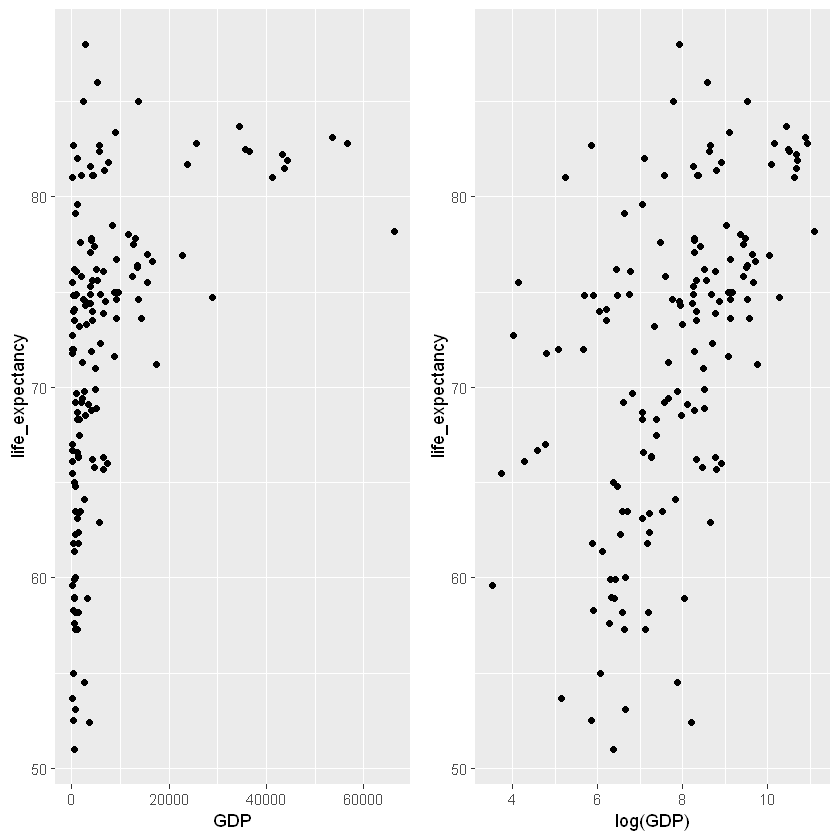

In [20]:
scat2_mod <- ggplot(data = df2, mapping = aes(x = log(GDP), y = life_expectancy)) + geom_point()
plot_grid(scat2, scat2_mod)

In [21]:
c(a1, b1) %<-% regression(log(df2$GDP), df2$life_expectancy, FALSE)
xs1 <- seq(min(log(df2$GDP)), max(log(df2$GDP)), 0.1)
reg2 <- ggplot() + geom_point(aes(log(df2$GDP), df2$life_expectancy), alpha = 0.5) + geom_line(aes(xs1, a1*xs1 + b1), col='red', linewidth=1)

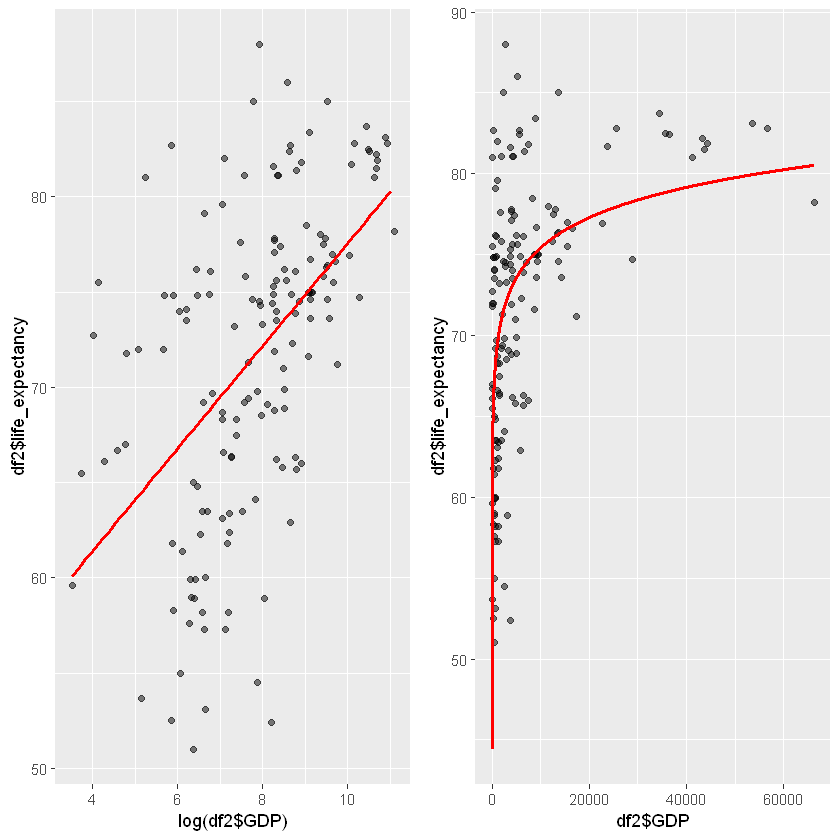

In [22]:
c(a2, b2) %<-% regression(log(df2$GDP), df2$life_expectancy, FALSE)
xs2 <- seq(0.1, max(df2$GDP), 10)
reg2_final <- ggplot() + geom_point(aes(df2$GDP, df2$life_expectancy), alpha = 0.5) + geom_line(aes(xs2, a2*log(xs2) + b2), col='red', linewidth=1)
plot_grid(reg2, reg2_final)

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


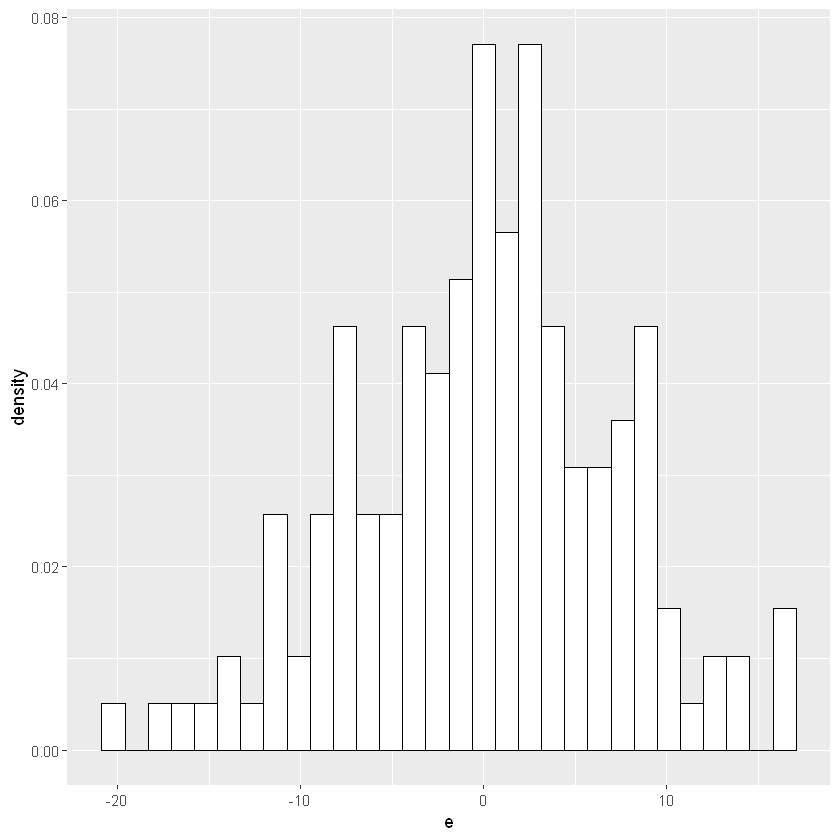

In [23]:
e <- df2$life_expectancy - a2*log(df2$GDP) - b2
hist_e <- ggplot(data.frame(e = e), aes(e)) + geom_histogram(aes(y = after_stat(density)), fill = 'white', color = 'black')
hist_e

In [24]:
mean(e)
sd(e)

[1] 5.282812e-15

[1] 7.069091

In [42]:
cor <- read.csv('data/correlations.csv')


[1] "adult_mortality"

In [40]:
t(cor)

X,adult_mortality,infant_deaths,alcohol,percentage_expenditure,hepatitis_B,measles,BMI,under_five_deaths,polio,total_expenditure,diphtheria,HIV_AIDS,GDP,population,thinness_1_19_years,thinness_5_9_years,income_composition_of_resources,schooling
X2000,-0.56,-0.58,0.43,0.52,0.14,-0.45,0.60,-0.61,0.58,0.30,0.52,-0.72,0.65,-0.14,-0.54,-0.54,0.72,0.77
X2001,-0.57,-0.61,0.41,0.49,0.18,-0.46,0.64,-0.63,0.57,0.28,0.60,-0.73,0.66,-0.32,-0.50,-0.50,0.78,0.76
X2002,-0.58,-0.62,0.44,0.53,0.30,-0.45,0.65,-0.63,0.57,0.26,0.58,-0.71,0.70,-0.13,-0.58,-0.55,0.77,0.76
X2003,-0.54,-0.61,0.43,0.54,0.35,-0.39,0.60,-0.63,0.59,0.25,0.59,-0.74,0.68,-0.17,-0.56,-0.57,0.79,0.77
X2004,-0.74,-0.62,0.44,0.51,0.32,-0.26,0.56,-0.63,0.49,0.25,0.56,-0.76,0.65,-0.07,-0.59,-0.60,0.80,0.78
X2005,-0.54,-0.61,0.44,0.54,0.34,-0.20,0.48,-0.62,0.49,0.26,0.52,-0.76,0.68,-0.02,-0.60,-0.67,0.82,0.78
X2006,-0.59,-0.62,0.46,0.53,0.33,-0.27,0.61,-0.63,0.51,0.31,0.52,-0.76,0.63,-0.17,-0.65,-0.70,0.89,0.82
X2007,-0.61,-0.61,0.45,0.49,0.36,-0.22,0.62,-0.63,0.50,0.30,0.54,-0.77,0.59,-0.14,-0.67,-0.67,0.89,0.81
X2008,-0.78,-0.61,0.45,0.46,0.39,-0.14,0.60,-0.62,0.53,0.19,0.52,-0.77,0.59,-0.17,-0.68,-0.67,0.88,0.79
X2009,-0.71,-0.60,0.43,0.51,0.36,-0.21,0.61,-0.63,0.43,0.31,0.47,-0.77,0.62,0.06,-0.67,-0.66,0.87,0.78
